In [0]:
! pip3 install torch torchvision tensorboardX
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip
from google.colab import drive
drive.mount('/content/gdrive')

    100% |████████████████████████████████| 133kB 6.3MB/s 
    100% |████████████████████████████████| 2.0MB 11.8MB/s 
imgaug 0.2.8 has requirement numpy>=1.15.0, but you'll have numpy 1.14.6 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


--2019-02-20 06:26:55--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 54.165.51.142, 54.174.228.92, 54.173.32.212, ...
Connecting to bin.equinox.io (bin.equinox.io)|54.165.51.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5363700 (5.1M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]   5.11M  9.54MB/s    in 0.5s    

2019-02-20 06:26:56 (9.54 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [5363700/5363700]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapi

In [0]:
import torch
import torch.nn as nn
import torch.autograd as autograd
from torch.autograd import Variable
import torch.nn.functional as F
import math
import numpy as np
import sys; 
from tensorboardX import SummaryWriter
import torchsummary
sys.path


['',
 '/env/python',
 '/usr/lib/python36.zip',
 '/usr/lib/python3.6',
 '/usr/lib/python3.6/lib-dynload',
 '/usr/local/lib/python3.6/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.6/dist-packages/IPython/extensions',
 '/root/.ipython']

In [0]:
import numpy as np
def F(x):
    return np.tanh(x+1e-60) - x
import scipy.optimize
x = scipy.optimize.newton_krylov(F, [1.5],verbose=1)
print(x)

0:  |F(x)| = 0.124728; step 1
1:  |F(x)| = 0.0333636; step 1
2:  |F(x)| = 0.00949792; step 1
3:  |F(x)| = 0.00276705; step 1
4:  |F(x)| = 0.000813865; step 1
5:  |F(x)| = 0.000240367; step 1
6:  |F(x)| = 7.11178e-05; step 1
7:  |F(x)| = 2.10586e-05; step 1
8:  |F(x)| = 6.23782e-06; step 1
9:  |F(x)| = 1.84801e-06; step 1
[0.01769947]


In [0]:
LOG_DIR = './logs'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)
get_ipython().system_raw('./ngrok http 6006 &')
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"


In [0]:
#parameters
num_res_layers = 7
cnn_num_filters = 16
cnn_kernel_size = 5
cnn_stride_size = 1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [0]:
def form_hamiltonian(sites=5, e_n = 1, t_n = 1):
    
    def gen_triples(N):
        i, j, k = (0, 0, 0)
        coords = []
        for i in range(N):
            for j in range(N):
                for k in range(N):
                    coords.append((i,j,k))

        return coords
    
    coords = gen_triples(sites)
    mapping = {i: coords[i] for i in range(len(coords))}
    inv_mapping = {coords[i]: i for i in range(len(coords))}
    H = np.zeros((sites ** 3, sites ** 3), dtype = complex)
    print(len(coords))
    for i in range(sites ** 3):
        x, y, z = mapping[i]
        H[i, i] = e_n
        if (z + 1 < sites):
            H[i, i+1] = t_n
        if y + 1 < sites:
            H[i, i+sites] = t_n
        if x + 1 < sites:
            H[i, i+sites**2] = t_n
        if z > 0:
            H[i, i-1] = t_n
        if y > 0:
            H[i, i-sites] = t_n
        if x > 0:
            H[i, i-sites**2] = t_n
            
    return gen_triples, H

gen_triples, H = form_hamiltonian()
H

125


array([[1.+0.j, 1.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [1.+0.j, 1.+0.j, 1.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j, 1.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       ...,
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 1.+0.j, 1.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 1.+0.j, 1.+0.j, 1.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 1.+0.j, 1.+0.j]])

In [0]:
H = torch.Tensor(np.real(H))
z = torch.zeros_like(H).fill_(3)
inp = torch.cat((H.unsqueeze(0), z.unsqueeze(0)), dim = 0)
inp = inp.unsqueeze(0)
inp.shape

torch.Size([1, 2, 125, 125])

In [0]:
inp

tensor([[[[1., 1., 0.,  ..., 0., 0., 0.],
          [1., 1., 1.,  ..., 0., 0., 0.],
          [0., 1., 1.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 1., 1., 0.],
          [0., 0., 0.,  ..., 1., 1., 1.],
          [0., 0., 0.,  ..., 0., 1., 1.]],

         [[3., 3., 3.,  ..., 3., 3., 3.],
          [3., 3., 3.,  ..., 3., 3., 3.],
          [3., 3., 3.,  ..., 3., 3., 3.],
          ...,
          [3., 3., 3.,  ..., 3., 3., 3.],
          [3., 3., 3.,  ..., 3., 3., 3.],
          [3., 3., 3.,  ..., 3., 3., 3.]]]])

In [0]:
from collections import OrderedDict
class CNNEncoder(nn.Module):
    """Maps a Hamiltonian and an energy input a hidden vector"""
    def __init__(self):
        super(CNNEncoder, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(2, cnn_num_filters, kernel_size=cnn_kernel_size, stride=cnn_stride_size, padding=2),
            nn.BatchNorm2d(cnn_num_filters),
            nn.ReLU())
        self.test = nn.Sequential(OrderedDict([
            ("first_conv", nn.Conv2d(2, cnn_num_filters, kernel_size=cnn_kernel_size, stride=cnn_stride_size, padding=2)),
            ("first_bn", nn.BatchNorm2d(cnn_num_filters))
        ]))
       
        self.resblock = [self._build_res_block(index) for index in range(cnn_num_filters)]
        self.final_encoder = nn.Sequential(OrderedDict([
            ("last_conv", nn.Conv2d(cnn_num_filters, 2, kernel_size=1, stride=cnn_stride_size, padding=2)),
            ("last_bn", nn.BatchNorm2d(2)),
            ("last_relu", nn.ReLU())
        ]))
        

    def forward(self, inputs):
        out = self.layer1(inputs)
        for _ in range(num_res_layers):
          res = out.clone()
          resblock = self.resblock[_]
          out = resblock(out) + res
        out = self.final_encoder(out)
        return out
      
    def _build_res_block(self, index):
        resblock = nn.Sequential(OrderedDict([
            ("conv1_resblock"+str(index), nn.Conv2d(cnn_num_filters, cnn_num_filters, kernel_size=cnn_kernel_size, stride=cnn_stride_size, padding=2)),
            ("bn1_resblock"+str(index), nn.BatchNorm2d(cnn_num_filters)),
            ("relu1_resblock"+str(index), nn.ReLU()),
            ("conv2_resblock"+str(index), nn.Conv2d(cnn_num_filters, cnn_num_filters, kernel_size=cnn_kernel_size, stride=cnn_stride_size, padding=2)),
            ("bn2_resblock"+str(index), nn.BatchNorm2d(cnn_num_filters)),
            ("relu1_resblock"+str(index), nn.ReLU())]))
        return resblock
    
v = CNNEncoder()

        
        
        
    
    
    
    

In [0]:
output = v(inp)
w = SummaryWriter(log_dir="./logs") 
w.add_graph(v, inp)
w.close()


In [0]:
torch.sum(output != 0)

tensor(9202)

In [0]:
output.view(1,-1).shape

torch.Size([1, 33282])

In [0]:
v = v.to(torch.device("cuda"))
torchsummary.summary(v.cpu(), (2, 125, 125))

RuntimeError: ignored

In [0]:
w = SummaryWriter(log_dir="./logs", comment='CNNEncoder') 
w.add_graph(v, inp)
w.close()


In [0]:

"a" + 1

TypeError: ignored

(array([3., 1., 5., 5., 5., 4., 6., 1., 3., 3.]),
 array([-0.22656 , -0.185154, -0.143748, -0.102342, -0.060936, -0.01953 ,
         0.021876,  0.063282,  0.104688,  0.146094,  0.1875  ]),
 <a list of 10 Patch objects>)

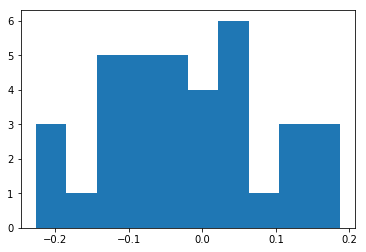

In [6]:
import matplotlib.pyplot as plt
plt.hist([0.04297, -0.05273, 0.01172, -0.02148, 0.06055, -0.00391, -0.13867, -0.07227, 0.03711, 0.13672, -0.08398, -0.01172, -0.09961, -0.08008, 0.18750, -0.19531, 0.04297, 0.04688, 0.13672, 0.12891, -0.12305, -0.02148, -0.02734, -0.19727, 0.15430, -0.11914, 0.07617, -0.07031, 0.15039, -0.22656, 0.00195, -0.14258, -0.02539, 0.04492, -0.13281, -0.14453, ])

(array([3., 6., 8., 9., 6., 7., 6., 6., 4., 1.]),
 array([-0.02981 , -0.023595, -0.01738 , -0.011165, -0.00495 ,  0.001265,
         0.00748 ,  0.013695,  0.01991 ,  0.026125,  0.03234 ]),
 <a list of 10 Patch objects>)

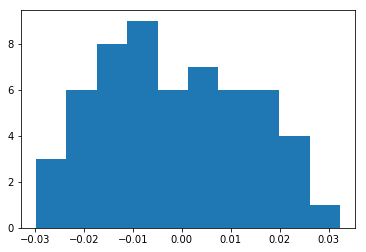

In [15]:
plt.hist([0.01279, -0.00888, 0.00202, -0.02012, 0.01106, 0.00419, -0.00994, 0.00434, -0.01490, 0.01703, -0.02350, -0.00933, -0.02306, -0.01535, -0.00713, -0.00641, -0.00209, 0.00329, 0.00731, -0.02981, -0.01261, 0.01978, -0.00852, 0.00315, -0.01782, -0.00252, -0.00913, 0.01498, -0.00531, -0.01543, 0.00112, -0.01706, -0.01362, 0.01553, 0.03234, 0.01504, -0.00223, -0.01910, -0.00915, 0.00159, -0.01282, -0.02472, -0.00250, 0.01086, 0.01325, 0.02578, -0.02320, 0.02033, 0.00870, 0.01479, -0.00086, 0.01169, -0.01336, 0.01997, 0.02275, -0.02738])

In [13]:
import numpy as np
np.mean([0.01279, -0.00888, 0.00202, -0.02012, 0.01106, 0.00419, -0.00994, 0.00434, -0.01490, 0.01703, -0.02350, -0.00933, -0.02306, -0.01535, -0.00713, -0.00641, -0.00209, 0.00329, 0.00731, -0.02981, -0.01261, 0.01978, -0.00852, 0.00315, -0.01782, -0.00252, -0.00913, 0.01498, -0.00531, -0.01543, 0.00112, -0.01706, -0.01362, 0.01553, 0.03234, 0.01504, -0.00223, -0.01910, -0.00915, 0.00159, -0.01282, -0.02472, -0.00250, 0.01086, 0.01325, 0.02578, -0.02320, 0.02033, 0.00870, 0.01479, -0.00086, 0.01169, -0.01336, 0.01997, 0.02275, -0.02738])

-0.001681785714285714

In [16]:
len([0.01279, -0.00888, 0.00202, -0.02012, 0.01106, 0.00419, -0.00994, 0.00434, -0.01490, 0.01703, -0.02350, -0.00933, -0.02306, -0.01535, -0.00713, -0.00641, -0.00209, 0.00329, 0.00731, -0.02981, -0.01261, 0.01978, -0.00852, 0.00315, -0.01782, -0.00252, -0.00913, 0.01498, -0.00531, -0.01543, 0.00112, -0.01706, -0.01362, 0.01553, 0.03234, 0.01504, -0.00223, -0.01910, -0.00915, 0.00159, -0.01282, -0.02472, -0.00250, 0.01086, 0.01325, 0.02578, -0.02320, 0.02033, 0.00870, 0.01479, -0.00086, 0.01169, -0.01336, 0.01997, 0.02275, -0.02738])

56

[0.0129684,
 0.0094851,
 0.0139947,
 0.0092324,
 0.0134036,
 0.0102338,
 0.0149733,
 0.0115867,
 0.0120618,
 0.0113302,
 0.0120463,
 0.0140954,
 0.0098438,
 0.0136781,
 0.0104105,
 0.012411,
 0.0094995,
 0.0118885,
 0.00454]

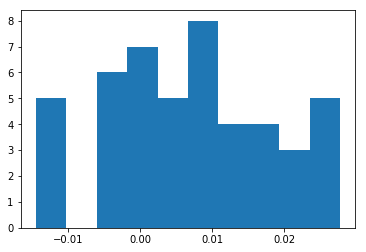

In [21]:
plt.hist([-0.00060, 0.00087, 0.00992, 0.02318, -0.01267, -0.00309, 0.00467, 0.00742, 0.01383, 0.01626, 0.01407, -0.00531, 0.01451, -0.00271, 0.01644, 0.00146, 0.02780, 0.00743, 0.00724, 0.02048, -0.00152, 0.01887, -0.00408, 0.00246, 0.01081, 0.00309, 0.00606, 0.02572, 0.02639, -0.01348, -0.01455, -0.00546, 0.00157, -0.01262, 0.01849, 0.02259, 0.00891, 0.00611, -0.00565, -0.00114, 0.01506, 0.02562, 0.02395, -0.01034, 0.00854, 0.00076, 0.00955, ])
([0.0129684, 0.0094851, 0.0139947, 0.0092324, 0.0134036, 0.0102338, 0.0149733, 0.0115867, 0.0120618, 0.0113302, 0.0120463, 0.0140954, 0.0098438, 0.0136781, 0.0104105, 0.0124110, 0.0094995, 0.0118885, 0.00454])

In [22]:
np.mean([-0.00060, 0.00087, 0.00992, 0.02318, -0.01267, -0.00309, 0.00467, 0.00742, 0.01383, 0.01626, 0.01407, -0.00531, 0.01451, -0.00271, 0.01644, 0.00146, 0.02780, 0.00743, 0.00724, 0.02048, -0.00152, 0.01887, -0.00408, 0.00246, 0.01081, 0.00309, 0.00606, 0.02572, 0.02639, -0.01348, -0.01455, -0.00546, 0.00157, -0.01262, 0.01849, 0.02259, 0.00891, 0.00611, -0.00565, -0.00114, 0.01506, 0.02562, 0.02395, -0.01034, 0.00854, 0.00076, 0.00955, ])

0.006955531914893617

In [38]:
32**2*(0.00696 - (-0.00168))/(0.001) 

8847.36

In [39]:
32**4*np.mean([0.0129684, 0.0094851, 0.0139947, 0.0092324, 0.0134036, 0.0102338, 0.0149733, 0.0115867, 0.0120618, 0.0113302, 0.0120463, 0.0140954, 0.0098438, 0.0136781, 0.0104105, 0.0124110, 0.0094995, 0.0118885, 0.00454]) / 3

4004.513583607017

In [36]:
16**2*0.5/3

42.666666666666664

In [37]:
0.01

160

In [40]:
np.mean([0.0129684, 0.0094851, 0.0139947, 0.0092324, 0.0134036, 0.0102338, 0.0149733, 0.0115867, 0.0120618, 0.0113302, 0.0120463, 0.0140954, 0.0098438, 0.0136781, 0.0104105, 0.0124110, 0.0094995, 0.0118885, 0.00454]) 

0.011457005263157894

In [41]:
32**2*0.003/0.001

3072.0

In [46]:
32**4/2*0.002

1048.576